In [1]:
import numpy as np
import math
import time

import os
import argparse

import matplotlib.pyplot as plt

from tqdm import tqdm

import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.layers import Dense, Conv1D, BatchNormalization, Activation
from tensorflow.keras.layers import Input, Cropping1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.python.ops import math_ops

from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
import tensorflow as tf
print(tf. __version__) 

2.6.0


In [2]:
def binarize_labels(labels, cell):
    #A549: [0.25, 0.5, 0.95, 0.98] [0.00000000e+00 3.53096163e-05 4.08277148e-02 1.01717487e-01] 
    # ~100K, 20K
    #293T: [0.25, 0.5, 0.95, 0.98] [0. 0.00223609 0.04327499 0.08719538]
    # ~100K, 40K
    #293T: [0.25, 0.5, 0.98, 0.99] [0. 0.00223609 0.08719538 0.12098964]
    # ~40K, 20K
    #293T: [0.25, 0.5, 0.9, 0.98]  [0.        , 0.0018268 , 0.02089392, 0.08125539]

    if cell=='A549':
    	q = [4.08277148e-02]
    else:
    	q = [0.02089392, 0.08125539]
    labels_ = []
    for x in labels:
        if x<=q[0]:
            labels_.append(np.array([0]))
        elif x>q[0]:
            labels_.append(np.array([1]))
    return np.array(labels_)


In [3]:
fpr_dict, tpr_dict, precision_dict, recall_dict = {}, {}, {}, {}
roc_auc_dict = {}
average_precision_dict = {}

# import

# ATAC

In [4]:
cell = '293T'

datadir = f'data_new/{cell}/inputs_numpy/test_1000nt/'

region = ['chr1', 'chr3', 'chr5', 'chr7', 'chr9']


firstseq, first27, firstatac, firstme1, first36, firstme3, firstlabels, first9 = 0,0,0,0,0,0,0,0

for chrn in region:
    with open(os.path.join(datadir, chrn+'_seqs.npy'), 'rb') as f: 
        x = np.load(f)
        if firstseq==0:
            seqs = x
            firstseq = 1
        else:
            seqs = np.concatenate((seqs, x), axis=0)
    with open(os.path.join(datadir, chrn+'_atac.npy'), 'rb') as f: 
        x = np.load(f)
        if firstatac==0:
            atac = x
            firstatac = 1
        else:
            atac = np.concatenate((atac, x), axis=0)
    with open(os.path.join(datadir, chrn+'_labels.npy'), 'rb') as f: 
        x = np.load(f)
        if firstlabels==0:
            labels = x
            firstlabels = 1
        else:
            labels = np.concatenate((labels, x), axis=0)




148260it [00:13, 11351.60it/s]


(148260, 5, 1000)


148260it [00:11, 12432.72it/s]


(148260, 5, 1000)


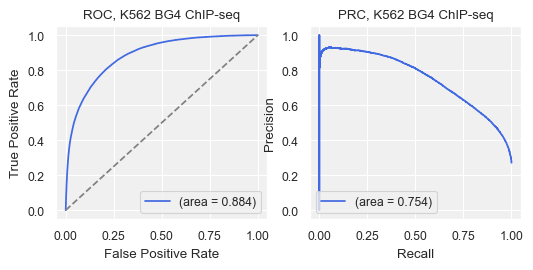

In [5]:
metadata = []

for s,ac in tqdm(zip(seqs,atac)):
    x = np.concatenate((s,ac.reshape(1, -1)), axis=0)
    metadata.append(x)
    
metadata = np.array(metadata)
print(np.shape(metadata))

labels_bin = binarize_labels(labels, cell)


metadata = []

for s,ac in tqdm(zip(seqs,atac)):
    x = np.concatenate((s,ac.reshape(1, -1)), axis=0)
    metadata.append(x)
    
metadata = np.array(metadata)
print(np.shape(metadata))

models_to_eval = os.listdir('./models_new/')

for model in models_to_eval:

    if model=='A549_1k_cls1_atac':
        input_shape = metadata.shape[1:]
        model_cnn = tf.keras.models.load_model(os.path.join('./models_new/', model, 'checkpoint'))
        y_pred = model_cnn.predict(metadata)


from sklearn import metrics

import seaborn as sns

sns.set_context('paper')
sns.set_style("darkgrid", {"axes.facecolor": ".94"})

colors = ['salmon', 'royalblue', 'darkolivegreen']
classes = ['0', '1']

fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

fpr, tpr, thresholds = metrics.roc_curve(labels_bin, y_pred)
roc_auc = metrics.auc(fpr, tpr)
precision, recall, _ = metrics.precision_recall_curve(labels_bin, y_pred)
average_precision = metrics.average_precision_score(labels_bin, y_pred)

fpr_dict['ATAC'] = fpr
tpr_dict['ATAC'] = tpr
precision_dict['ATAC'] = precision
recall_dict['ATAC'] = recall
roc_auc_dict['ATAC'] = roc_auc
average_precision_dict['ATAC'] = average_precision

#plt.figure()
#fig = plt.gcf()
lw = 1.25

fig, (ax1, ax2) = plt.subplots(1,2)
#fig.set_size_inches(9, 3.5)
fig.set_size_inches(6, 2.5)

ax1.plot(fpr, tpr, color=colors[1],
     lw=lw, label=f'(area = %0.3f)' % roc_auc)
ax2.plot(recall, precision, color=colors[1],
     lw=lw, label=f'(area = %0.3f)' % average_precision)

ax1.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC, K562 BG4 ChIP-seq')
ax1.legend(loc="lower right")

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PRC, K562 BG4 ChIP-seq')
ax2.legend(loc="lower left")

plt.show()
#fig.savefig('figures/A549_cls1_me3_K562.eps', dpi=300, format='eps', bbox_inches='tight')


# Seq

148260it [00:15, 9791.61it/s]


(148260, 5, 1000)
4634/4634 [==============================] - 26s 5ms/step - loss: 0.5448 - accuracy: 0.0000e+00
loss : 0.5448201298713684
accuracy : 0.0


<Figure size 550x200 with 0 Axes>

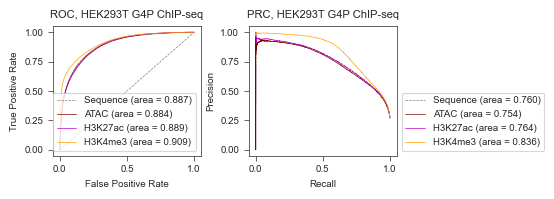

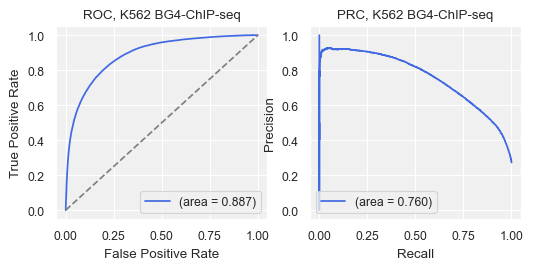

In [11]:

cell = '293T'

datadir = f'data_new/{cell}/inputs_numpy/test_1000nt/'

region = ['chr1', 'chr3', 'chr5', 'chr7', 'chr9']


firstseq, first27, firstatac, firstme1, first36, firstme3, firstlabels, first9 = 0,0,0,0,0,0,0,0

for chrn in region:
    with open(os.path.join(datadir, chrn+'_seqs.npy'), 'rb') as f: 
        x = np.load(f)
        if firstseq==0:
            seqs = x
            firstseq = 1
        else:
            seqs = np.concatenate((seqs, x), axis=0)
    with open(os.path.join(datadir, chrn+'_me3.npy'), 'rb') as f: 
        x = np.load(f)
        if firstme3==0:
            me3 = x
            firstme3 = 1
        else:
            me3 = np.concatenate((me3, x), axis=0)
    with open(os.path.join(datadir, chrn+'_k27ac.npy'), 'rb') as f: 
        x = np.load(f)
        if first27==0:
            k27 = x
            first27 = 1
        else:
            k27 = np.concatenate((k27, x), axis=0)
    with open(os.path.join(datadir, chrn+'_labels.npy'), 'rb') as f: 
        x = np.load(f)
        if firstlabels==0:
            labels = x
            firstlabels = 1
        else:
            labels = np.concatenate((labels, x), axis=0)


metadata = []

for s,m3 in tqdm(zip(seqs,me3)):
    x = np.concatenate((s,m3.reshape(1, -1)), axis=0)
    metadata.append(x)
    
metadata = np.array(metadata)
print(np.shape(metadata))

labels_bin = binarize_labels(labels, cell)

models_to_eval = os.listdir('./models_new/')

for model in models_to_eval:

    if model=='A549_1k_cls1_seq':
        input_shape = seqs.shape[1:]
        model_cnn = tf.keras.models.load_model(os.path.join('./models_new/', model, 'checkpoint'))

        results = model_cnn.evaluate(seqs, labels_bin)
        metrics = dict(zip(model_cnn.metrics_names, results))

        y_pred = model_cnn.predict(seqs)
        
        for key in metrics.keys():
            print(f"{key} : {metrics[key]}")

from sklearn import metrics

import seaborn as sns

sns.set_context('paper')
sns.set_style("darkgrid", {"axes.facecolor": ".94"})

colors = ['salmon', 'royalblue', 'darkolivegreen']
classes = ['0', '1']

fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

fpr, tpr, thresholds = metrics.roc_curve(labels_bin, y_pred)
roc_auc = metrics.auc(fpr, tpr)
precision, recall, _ = metrics.precision_recall_curve(labels_bin, y_pred)
average_precision = metrics.average_precision_score(labels_bin, y_pred)

fpr_dict['Sequence'] = fpr
tpr_dict['Sequence'] = tpr
precision_dict['Sequence'] = precision
recall_dict['Sequence'] = recall
roc_auc_dict['Sequence'] = roc_auc
average_precision_dict['Sequence'] = average_precision

#plt.figure()
#fig = plt.gcf()
lw = 1.25

fig, (ax1, ax2) = plt.subplots(1,2)
#fig.set_size_inches(9, 3.5)
fig.set_size_inches(6, 2.5)

ax1.plot(fpr, tpr, color=colors[1],
     lw=lw, label=f'(area = %0.3f)' % roc_auc)
ax2.plot(recall, precision, color=colors[1],
     lw=lw, label=f'(area = %0.3f)' % average_precision)

ax1.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC, K562 BG4-ChIP-seq')
ax1.legend(loc="lower right")

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PRC, K562 BG4-ChIP-seq')
ax2.legend(loc="lower left")

plt.show()
#fig.savefig('figures/A549_cls1_me3_K562.eps', dpi=300, format='eps', bbox_inches='tight')


# k27ac

148260it [00:14, 10202.03it/s]


(148260, 5, 1000)
4634/4634 [==============================] - 22s 5ms/step - loss: 0.4309 - accuracy: 0.0000e+00
loss : 0.43093541264533997
accuracy : 0.0


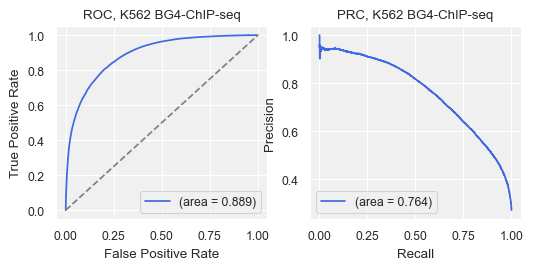

In [7]:
metadata = []

for s,ac in tqdm(zip(seqs,k27)):
    x = np.concatenate((s,ac.reshape(1, -1)), axis=0)
    metadata.append(x)
    
metadata = np.array(metadata)
print(np.shape(metadata))


models_to_eval = os.listdir('./models_new/')

for model in models_to_eval:

    if model=='A549_1k_cls1_k27ac':
        input_shape = metadata.shape[1:]
        model_cnn = tf.keras.models.load_model(os.path.join('./models_new/', model, 'checkpoint'))

        results = model_cnn.evaluate(metadata, labels_bin)
        metrics = dict(zip(model_cnn.metrics_names, results))

        y_pred = model_cnn.predict(metadata)
        
        for key in metrics.keys():
            print(f"{key} : {metrics[key]}")
    

from sklearn import metrics

import seaborn as sns

sns.set_context('paper')
sns.set_style("darkgrid", {"axes.facecolor": ".94"})

colors = ['salmon', 'royalblue', 'darkolivegreen']
classes = ['0', '1']

fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

fpr, tpr, thresholds = metrics.roc_curve(labels_bin, y_pred)
roc_auc = metrics.auc(fpr, tpr)
precision, recall, _ = metrics.precision_recall_curve(labels_bin, y_pred)
average_precision = metrics.average_precision_score(labels_bin, y_pred)

fpr_dict['H3K27ac'] = fpr
tpr_dict['H3K27ac'] = tpr
precision_dict['H3K27ac'] = precision
recall_dict['H3K27ac'] = recall
roc_auc_dict['H3K27ac'] = roc_auc
average_precision_dict['H3K27ac'] = average_precision

#plt.figure()
#fig = plt.gcf()
lw = 1.25

fig, (ax1, ax2) = plt.subplots(1,2)
#fig.set_size_inches(9, 3.5)
fig.set_size_inches(6, 2.5)

ax1.plot(fpr, tpr, color=colors[1],
     lw=lw, label=f'(area = %0.3f)' % roc_auc)
ax2.plot(recall, precision, color=colors[1],
     lw=lw, label=f'(area = %0.3f)' % average_precision)

ax1.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC, K562 BG4-ChIP-seq')
ax1.legend(loc="lower right")

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PRC, K562 BG4-ChIP-seq')
ax2.legend(loc="lower left")

plt.show()
#fig.savefig('figures/A549_cls1_me3_K562.eps', dpi=300, format='eps', bbox_inches='tight')


# H3K4me3

148260it [00:19, 7725.03it/s]


(148260, 5, 1000)
4634/4634 [==============================] - 23s 5ms/step - loss: 0.5975 - accuracy: 0.0000e+00
loss : 0.5974920988082886
accuracy : 0.0


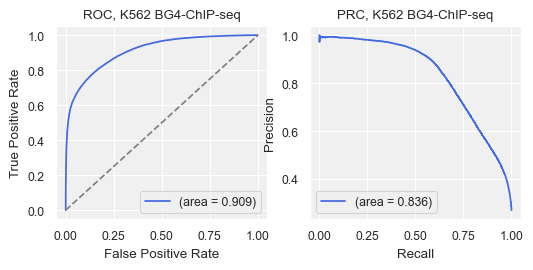

In [8]:
metadata = []

for s,m3 in tqdm(zip(seqs,me3)):
    x = np.concatenate((s,m3.reshape(1, -1)), axis=0)
    metadata.append(x)
    
metadata = np.array(metadata)
print(np.shape(metadata))

labels_bin = binarize_labels(labels, cell)

models_to_eval = os.listdir('./models_new/')

for model in models_to_eval:

    if model=='A549_1k_cls1_k4me3':
        input_shape = metadata.shape[1:]
        model_cnn = tf.keras.models.load_model(os.path.join('./models_new/', model, 'checkpoint'))

        results = model_cnn.evaluate(metadata, labels_bin)
        metrics = dict(zip(model_cnn.metrics_names, results))

        y_pred = model_cnn.predict(metadata)
        
        for key in metrics.keys():
            print(f"{key} : {metrics[key]}")


from sklearn import metrics

import seaborn as sns

sns.set_context('paper')
sns.set_style("darkgrid", {"axes.facecolor": ".94"})

colors = ['salmon', 'royalblue', 'darkolivegreen']
classes = ['0', '1']

fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

fpr, tpr, thresholds = metrics.roc_curve(labels_bin, y_pred)
roc_auc = metrics.auc(fpr, tpr)
precision, recall, _ = metrics.precision_recall_curve(labels_bin, y_pred)
average_precision = metrics.average_precision_score(labels_bin, y_pred)

fpr_dict['H3K4me3'] = fpr
tpr_dict['H3K4me3'] = tpr
precision_dict['H3K4me3'] = precision
recall_dict['H3K4me3'] = recall
roc_auc_dict['H3K4me3'] = roc_auc
average_precision_dict['H3K4me3'] = average_precision

#plt.figure()
#fig = plt.gcf()
lw = 1.25

fig, (ax1, ax2) = plt.subplots(1,2)
#fig.set_size_inches(9, 3.5)
fig.set_size_inches(6, 2.5)

ax1.plot(fpr, tpr, color=colors[1],
     lw=lw, label=f'(area = %0.3f)' % roc_auc)
ax2.plot(recall, precision, color=colors[1],
     lw=lw, label=f'(area = %0.3f)' % average_precision)

ax1.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC, K562 BG4-ChIP-seq')
ax1.legend(loc="lower right")

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PRC, K562 BG4-ChIP-seq')
ax2.legend(loc="lower left")

plt.show()
#fig.savefig('figures/A549_cls1_me3_K562.eps', dpi=300, format='eps', bbox_inches='tight')


# Plot all

In [12]:
colors = ['gray','maroon','m', 'orange', 'royalblue', 'forestgreen',  'salmon',  'limegreen']
marks = ['Sequence', 'ATAC', 'H3K27ac', 'H3K4me3']

sns.set_context('paper')
#sns.set_style("darkgrid", {"axes.facecolor": ".94"})
sns.set_style("ticks")
sns.set_context("paper")

plt.rcParams["figure.figsize"] = [5.5,2]
plt.rcParams['font.family'] = ['arial']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7 
plt.rcParams['axes.linewidth']=0.5
plt.rcParams['xtick.minor.width']=0.5
plt.rcParams['ytick.minor.width']=0.5
plt.rcParams['xtick.major.width']=0.5
plt.rcParams['ytick.major.width']=0.5
plt.rcParams['xtick.major.size']=3.5
plt.rcParams['ytick.major.size']=3.5
 
lw = 0.5

plt.close()
plt.clf()

fig, (ax1, ax2) = plt.subplots(1,2)
#fig.set_size_inches(9, 3.5)
#fig.set_size_inches(9, 3.5)

for mark,color in zip(marks, colors):
    if mark!='Sequence':
        ax1.plot(fpr_dict[mark], tpr_dict[mark], color=color,
             lw=lw, label=f'{mark} (area = %0.3f)' % roc_auc_dict[mark])
        ax2.plot(recall_dict[mark], precision_dict[mark], color=color,
             lw=lw, label=f'{mark} (area = %0.3f)' % average_precision_dict[mark])
    else:
        ax1.plot(fpr_dict[mark], tpr_dict[mark], color=color,linestyle='--',
             lw=lw, label=f'{mark} (area = %0.3f)' % roc_auc_dict[mark])
        ax2.plot(recall_dict[mark], precision_dict[mark], color=color,linestyle='--',
             lw=lw, label=f'{mark} (area = %0.3f)' % average_precision_dict[mark])

#ax1.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')

ax1.set_xlabel('False Positive Rate', fontsize=7)
ax1.set_ylabel('True Positive Rate', fontsize=7)
ax1.set_title('ROC, HEK293T G4P ChIP-seq', fontsize=8)
ax1.legend(loc="lower right", fontsize=7)

ax2.set_xlabel('Recall', fontsize=7)
ax2.set_ylabel('Precision', fontsize=7)
ax2.set_title('PRC, HEK293T G4P ChIP-seq', fontsize=8)
ax2.legend(loc="lower left", bbox_to_anchor=(1, 0), fontsize=7)
#ax2.legend(loc="upper right")#, bbox_to_anchor=(1, 0))

fig.tight_layout()

fig.savefig('figures/HEK293T_G4P_1k_allmethods_smaller.pdf', dpi=300, format='pdf', bbox_inches='tight')
